Test using the feature vector extracted with soundnet-pytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

In [2]:

from nilearn.image import mean_img
from nilearn.plotting import plot_anat
from nilearn.input_data import NiftiMasker

from nilearn.plotting import plot_stat_map,plot_glass_brain

/home/brain/miniconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import pandas as pd
from sklearn.linear_model import Ridge,RidgeCV
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
from tqdm import tqdm

In [4]:
def load_fmri(id,localpath = "/home/brain/datasets/SherlockMerlin_ds001110/sub-"):

    filename_mask = "{}{:02d}/func/sub-{:02d}_task-SherlockMovie_bold_space-T1w_brainmask.nii.gz".format(
                localpath,id,id)

    masker = NiftiMasker(mask_img=filename_mask, detrend=True,standardize=True)
    masker.fit()

    filename_irm = "{}{:02d}/func/sub-{:02d}_task-SherlockMovie_bold_space-T1w_preproc.nii.gz".format(
                localpath,id,id)
    
    fmri_data = masker.transform(filename_irm)
    fmri_mean = mean_img(filename_irm)
    return fmri_data,fmri_mean,masker

https://nilearn.github.io/auto_examples/02_decoding/plot_miyawaki_encoding.html

> Using 4-fold cross-validation, we partition the data into 4 ‘folds’. We hold out each fold of the data for testing, then fit a ridge regression to the remaining 3/4 of the data, using stimuli as predictors and fmri_data as targets, and create predictions for the held-out 4th.



In [24]:
#using the feature vector as stimuli
#to predict the neuronal activity in this voxel. (Pytorchmodel)

def get_scores(subject,id_layer,
               fmri_data,splits = 4, 
               alphas = np.logspace(-10,2, 5),
               folder = 'sherlock_pytorch'):
    curnpz = "/home/brain/Desktop/BrainSongs/fmri_video/features/soundnet_fv_pytorch_2019/"
    curnpz = "{}{}/conv{}.npz".format(curnpz,folder,id_layer+1)
    fv = np.load(curnpz)['fv']

    # Check the size
    print("{} time points, dimension of the FV is {}, layer conv{}".format(
            fv.shape[0],fv.shape[1],id_layer+1))
   
    fmri_data = fmri_data[17:-(fmri_data.shape[0]-17-fv.shape[0])]
    print(fmri_data.shape)

    stimuli = fv
    dim = fv.shape[1]
    cv = KFold(n_splits=splits)
    
    #alpha log
    
    print(alphas)
    scores = []
    
    for train, test in tqdm(cv.split(X=stimuli)):
        # we train the Ridge estimator on the training set
        # and predict the fMRI activity for the test set
        estimator = RidgeCV(alphas=alphas).fit(stimuli.reshape(-1, dim)[train], fmri_data[train])
        print("alpha : ",estimator.alpha_)
        predictions = estimator.predict(stimuli.reshape(-1, dim)[test])
        # we compute how much variance our encoding model explains in each voxel
        scores.append(r2_score(fmri_data[test], predictions,
                               multioutput='raw_values'))
    #To plot the scores onto the brain, we create a Nifti1Image containing the scores 
    cut_score = np.mean(scores, axis=0)
    cut_score[cut_score < 0] = 0    
    return cut_score

In [25]:
def get_best_layers(id_subject,fmri_data,folder,splits=4, save = True):
    df = pd.DataFrame()
    for id_layer in range(7):
        name = 'conv{}'.format(id_layer+1) 
        conv = get_scores(id_subject,id_layer,fmri_data,splits,folder = folder)
        df[name] = conv
    
    print(df.describe())
    best_scores = pd.DataFrame({'scores' : df.max(axis=1),'layer':df.idxmax(axis=1)})
    
    print(best_scores.describe())
    
    if save:
        np.savez_compressed('./results/sub{:02d}_best_scores.npz'.format(id_subject), 
                        scores = best_scores['scores'],layer = best_scores['layer'])
        print('DataFrame Best_scores saved: {R2score,layer}')
    return best_scores
    

In [6]:
def plot_mri(subject,masker,best_scores,save = True):
# bring the scores into the shape of the background brain
    title = "Subject no {:02d}".format(subject)
    fig = plt.figure()
    score_map_img = masker.inverse_transform(best_scores['scores'])    
    plot_stat_map(score_map_img,bg_img=fmri_mean, title = title,figure = fig)
    
    if save:
        fig.savefig('./results/sub{:02d}.png'.format(subject))
    fig, ax = plt.subplots(3,1, figsize = (15,7))
    plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='x',title = title,axes=ax[0])
    plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='y',axes=ax[1])
    plot_stat_map(score_map_img,bg_img=fmri_mean,cut_coords=8,display_mode='z',axes=ax[2])
    plt.show()
    
    if save:
        fig.savefig('./results/sub{:02d}_xyz.png'.format(subject))
                 
    

------------------------------------------------------

# Analyse sherlock

folder features *get_scores* : `"/home/brain/Desktop/BrainSongs/fmri_video/features/soundnet_fv_pytorch_2019/sherlock_pytorch/"`

folder fmri *load_fmri* : `"/home/brain/datasets/SherlockMerlin_ds001110/"`

In [120]:
 #loadsubjet
subject = 1
fmri_data, fmri_mean,masker = load_fmri(subject)
best_scores = get_best_layers(subject,fmri_data)


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 44690)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.99s/it]

alpha :  0.0001


2it [00:09,  4.99s/it]

alpha :  0.0001


3it [00:14,  4.99s/it]

alpha :  0.0001


4it [00:19,  4.99s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 44690)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.11s/it]

alpha :  0.0001


2it [00:10,  5.10s/it]

alpha :  0.0001


3it [00:15,  5.15s/it]

alpha :  0.0001


4it [00:20,  5.17s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 44690)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.19s/it]

alpha :  0.1


2it [00:10,  5.17s/it]

alpha :  0.1


3it [00:15,  5.16s/it]

alpha :  0.1


4it [00:21,  5.31s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 44690)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.62s/it]

alpha :  0.1


2it [00:12,  6.29s/it]

alpha :  0.1


3it [00:17,  6.08s/it]

alpha :  0.1


4it [00:23,  5.92s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 44690)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.18s/it]

alpha :  0.1


2it [00:12,  6.22s/it]

alpha :  0.1


3it [00:18,  6.25s/it]

alpha :  0.1


4it [00:24,  6.19s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 44690)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  100.0


1it [00:07,  7.39s/it]

alpha :  100.0


2it [00:14,  7.40s/it]

alpha :  100.0


3it [00:22,  7.41s/it]

alpha :  100.0


4it [00:29,  7.42s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 44690)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.91s/it]

alpha :  0.1


2it [00:16,  8.05s/it]

alpha :  0.1


3it [00:24,  8.24s/it]

alpha :  0.1


4it [00:33,  8.24s/it]

              conv1         conv2         conv3         conv4         conv5  \
count  44690.000000  44690.000000  44690.000000  44690.000000  44690.000000   
mean       0.000405      0.000413      0.000216      0.000689      0.000498   
std        0.003066      0.003350      0.002224      0.004315      0.004940   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.158795      0.149159      0.072646      0.145372      0.148040   

              conv6         conv7  
count  44690.000000  44690.000000  
mean       0.000107      0.001660  
std        0.001094      0.011994  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


### 2 - 5

In [136]:
 for i in range(2,5):
    subject = i
    fmri_data, fmri_mean,masker = load_fmri(subject)
    best_scores = get_best_layers(subject,fmri_data)

0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 22226)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]


1it [00:02,  2.59s/it]

alpha :  1e-07


2it [00:05,  2.64s/it]

alpha :  0.0001


3it [00:07,  2.60s/it]

alpha :  0.0001


4it [00:10,  2.58s/it]
0it [00:00, ?it/s]

alpha :  0.0001
946 time points, dimension of the FV is 32, layer conv2
(946, 22226)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]


1it [00:02,  2.50s/it]

alpha :  0.0001


2it [00:04,  2.49s/it]

alpha :  0.0001


3it [00:07,  2.49s/it]

alpha :  0.0001


4it [00:09,  2.48s/it]
0it [00:00, ?it/s]

alpha :  0.0001
946 time points, dimension of the FV is 64, layer conv3
(946, 22226)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]


1it [00:02,  2.51s/it]

alpha :  0.0001


2it [00:04,  2.50s/it]

alpha :  0.0001


3it [00:07,  2.50s/it]

alpha :  0.0001


4it [00:09,  2.49s/it]
0it [00:00, ?it/s]

alpha :  0.0001
946 time points, dimension of the FV is 128, layer conv4
(946, 22226)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]


1it [00:02,  2.56s/it]

alpha :  0.1


2it [00:05,  2.56s/it]

alpha :  0.1


3it [00:07,  2.56s/it]

alpha :  0.1


4it [00:10,  2.56s/it]
0it [00:00, ?it/s]

alpha :  0.1
946 time points, dimension of the FV is 256, layer conv5
(946, 22226)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]


1it [00:02,  2.93s/it]

alpha :  0.1


2it [00:05,  2.93s/it]

alpha :  0.1


3it [00:08,  2.93s/it]

alpha :  0.1


4it [00:11,  2.93s/it]
0it [00:00, ?it/s]

alpha :  0.1
946 time points, dimension of the FV is 512, layer conv6
(946, 22226)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]


1it [00:03,  3.62s/it]

alpha :  0.1


2it [00:07,  3.62s/it]

alpha :  0.1


3it [00:10,  3.62s/it]

alpha :  0.1


4it [00:14,  3.63s/it]

alpha :  0.1



0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 22226)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:03,  3.85s/it]

alpha :  0.1


2it [00:07,  3.86s/it]

alpha :  0.1


3it [00:11,  3.86s/it]

alpha :  0.1


4it [00:15,  3.86s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  22226.000000  22226.000000  22226.000000  22226.000000  22226.000000   
mean       0.000004      0.000019      0.000011      0.000024      0.000045   
std        0.000232      0.000634      0.000437      0.000625      0.001498   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.023002      0.048202      0.034551      0.051386      0.089510   

              conv6         conv7  
count  22226.000000  22226.000000  
mean       0.000007      0.000091  
std        0.000471      0.003213  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 45581)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.97s/it]

alpha :  0.0001


2it [00:09,  4.97s/it]

alpha :  0.0001


3it [00:14,  4.97s/it]

alpha :  0.0001


4it [00:19,  4.97s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 45581)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.99s/it]

alpha :  0.0001


2it [00:09,  4.99s/it]

alpha :  0.0001


3it [00:14,  4.99s/it]

alpha :  0.0001


4it [00:19,  4.99s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 45581)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.07s/it]

alpha :  0.1


2it [00:10,  5.05s/it]

alpha :  0.1


3it [00:15,  5.06s/it]

alpha :  0.0001


4it [00:20,  5.07s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 45581)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.30s/it]

alpha :  0.1


2it [00:10,  5.30s/it]

alpha :  0.1


3it [00:15,  5.30s/it]

alpha :  0.1


4it [00:21,  5.31s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 45581)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.93s/it]

alpha :  0.1


2it [00:11,  5.93s/it]

alpha :  0.1


3it [00:17,  5.93s/it]

alpha :  0.1


4it [00:23,  5.93s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 45581)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  100.0


1it [00:07,  7.27s/it]

alpha :  100.0


2it [00:14,  7.27s/it]

alpha :  100.0


3it [00:21,  7.27s/it]

alpha :  100.0


4it [00:29,  7.28s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 45581)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.71s/it]

alpha :  0.1


2it [00:15,  7.71s/it]

alpha :  0.1


3it [00:23,  7.71s/it]

alpha :  0.1


4it [00:30,  7.71s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  45581.000000  45581.000000  45581.000000  45581.000000  45581.000000   
mean       0.000198      0.000227      0.000056      0.000316      0.000291   
std        0.002469      0.002824      0.001224      0.003043      0.003992   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.141739      0.162474      0.091387      0.150413      0.145089   

              conv6         conv7  
count  45581.000000  45581.000000  
mean       0.000071      0.001100  
std        0.000955      0.010471  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 47291)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  1e-07


1it [00:05,  5.16s/it]

alpha :  0.0001


2it [00:10,  5.16s/it]

alpha :  0.0001


3it [00:15,  5.16s/it]

alpha :  0.0001


4it [00:20,  5.16s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 47291)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.18s/it]

alpha :  0.0001


2it [00:10,  5.19s/it]

alpha :  0.0001


3it [00:15,  5.19s/it]

alpha :  0.0001


4it [00:20,  5.20s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 47291)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.30s/it]

alpha :  0.0001


2it [00:10,  5.29s/it]

alpha :  0.0001


3it [00:15,  5.28s/it]

alpha :  0.0001


4it [00:21,  5.28s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 47291)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.53s/it]

alpha :  0.1


2it [00:11,  5.53s/it]

alpha :  0.1


3it [00:16,  5.52s/it]

alpha :  0.1


4it [00:22,  5.52s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 47291)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.15s/it]

alpha :  0.1


2it [00:12,  6.14s/it]

alpha :  0.1


3it [00:18,  6.14s/it]

alpha :  0.1


4it [00:24,  6.15s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 47291)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.58s/it]

alpha :  0.1


2it [00:15,  7.57s/it]

alpha :  0.1


3it [00:22,  7.57s/it]

alpha :  0.1


4it [00:30,  7.56s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 47291)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:08,  8.02s/it]

alpha :  0.1


2it [00:16,  8.02s/it]

alpha :  0.1


3it [00:24,  8.03s/it]

alpha :  0.1


4it [00:32,  8.03s/it]

              conv1         conv2         conv3         conv4         conv5  \
count  47291.000000  47291.000000  47291.000000  47291.000000  47291.000000   
mean       0.000007      0.000018      0.000007      0.000035      0.000015   
std        0.000491      0.000706      0.000459      0.000891      0.000673   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.085225      0.084063      0.067853      0.075106      0.071300   

              conv6         conv7  
count  47291.000000  47291.000000  
mean       0.000008      0.000045  
std        0.000525      0.001901  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


In [137]:
 for i in range(6,10):
    subject = i
    fmri_data, fmri_mean,masker = load_fmri(subject)
    best_scores = get_best_layers(subject,fmri_data)

0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 45969)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.02s/it]

alpha :  0.0001


2it [00:10,  5.01s/it]

alpha :  0.0001


3it [00:15,  5.01s/it]

alpha :  0.0001


4it [00:20,  5.01s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 45969)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.04s/it]

alpha :  0.0001


2it [00:10,  5.04s/it]

alpha :  0.0001


3it [00:15,  5.04s/it]

alpha :  0.0001


4it [00:20,  5.04s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 45969)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.20s/it]

alpha :  0.0001


2it [00:10,  5.18s/it]

alpha :  0.0001


3it [00:15,  5.19s/it]

alpha :  0.0001


4it [00:20,  5.18s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 45969)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.38s/it]

alpha :  0.1


2it [00:10,  5.37s/it]

alpha :  0.1


3it [00:16,  5.37s/it]

alpha :  0.1


4it [00:21,  5.37s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 45969)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.97s/it]

alpha :  0.1


2it [00:11,  5.98s/it]

alpha :  0.1


3it [00:17,  5.98s/it]

alpha :  0.1


4it [00:23,  5.98s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 45969)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.33s/it]

alpha :  0.1


2it [00:14,  7.33s/it]

alpha :  100.0


3it [00:21,  7.33s/it]

alpha :  100.0


4it [00:29,  7.33s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 45969)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.81s/it]

alpha :  0.1


2it [00:15,  7.81s/it]

alpha :  0.1


3it [00:23,  7.81s/it]

alpha :  0.1


4it [00:31,  7.81s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  45969.000000  45969.000000  45969.000000  45969.000000  45969.000000   
mean       0.000067      0.000100      0.000024      0.000140      0.000096   
std        0.000904      0.001378      0.000710      0.001578      0.001875   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.044822      0.084227      0.059176      0.079362      0.094223   

              conv6         conv7  
count  45969.000000  45969.000000  
mean       0.000025      0.000406  
std        0.000841      0.004741  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 46910)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.20s/it]

alpha :  0.0001


2it [00:10,  5.20s/it]

alpha :  0.0001


3it [00:15,  5.20s/it]

alpha :  0.0001


4it [00:20,  5.20s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 46910)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.14s/it]

alpha :  0.0001


2it [00:10,  5.14s/it]

alpha :  0.0001


3it [00:15,  5.14s/it]

alpha :  0.0001


4it [00:20,  5.14s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 46910)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.21s/it]

alpha :  0.1


2it [00:10,  5.21s/it]

alpha :  0.1


3it [00:15,  5.21s/it]

alpha :  0.1


4it [00:20,  5.21s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 46910)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.46s/it]

alpha :  0.1


2it [00:10,  5.46s/it]

alpha :  0.1


3it [00:16,  5.46s/it]

alpha :  0.1


4it [00:21,  5.46s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 46910)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.18s/it]

alpha :  0.1


2it [00:12,  6.18s/it]

alpha :  0.1


3it [00:18,  6.17s/it]

alpha :  0.1


4it [00:24,  6.17s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 46910)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  100.0


1it [00:07,  7.48s/it]

alpha :  100.0


2it [00:14,  7.49s/it]

alpha :  100.0


3it [00:22,  7.49s/it]

alpha :  100.0


4it [00:29,  7.49s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 46910)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.97s/it]

alpha :  0.1


2it [00:15,  7.97s/it]

alpha :  0.1


3it [00:23,  7.97s/it]

alpha :  0.1


4it [00:31,  7.97s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  46910.000000  46910.000000  46910.000000  46910.000000  46910.000000   
mean       0.000182      0.000162      0.000059      0.000245      0.000195   
std        0.002866      0.002608      0.001340      0.003026      0.003093   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.124139      0.124893      0.069073      0.135071      0.116871   

              conv6         conv7  
count  46910.000000  46910.000000  
mean       0.000040      0.000919  
std        0.000654      0.008831  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 45069)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.92s/it]

alpha :  0.0001


2it [00:09,  4.92s/it]

alpha :  0.0001


3it [00:14,  4.92s/it]

alpha :  0.0001


4it [00:19,  4.92s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 45069)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.95s/it]

alpha :  0.0001


2it [00:09,  4.95s/it]

alpha :  0.0001


3it [00:14,  4.95s/it]

alpha :  0.0001


4it [00:19,  4.95s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 45069)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:05,  5.04s/it]

alpha :  0.0001


2it [00:10,  5.02s/it]

alpha :  0.0001


3it [00:15,  5.02s/it]

alpha :  0.0001


4it [00:20,  5.02s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 45069)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.38s/it]

alpha :  0.1


2it [00:10,  5.38s/it]

alpha :  0.1


3it [00:16,  5.37s/it]

alpha :  0.1


4it [00:21,  5.37s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 45069)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.92s/it]

alpha :  0.1


2it [00:11,  5.92s/it]

alpha :  0.1


3it [00:17,  5.92s/it]

alpha :  0.1


4it [00:23,  5.92s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 45069)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.26s/it]

alpha :  0.1


2it [00:14,  7.26s/it]

alpha :  0.1


3it [00:21,  7.27s/it]

alpha :  0.1


4it [00:29,  7.29s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 45069)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.69s/it]

alpha :  0.1


2it [00:15,  7.70s/it]

alpha :  0.1


3it [00:23,  7.71s/it]

alpha :  0.1


4it [00:30,  7.72s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  45069.000000  45069.000000  45069.000000  45069.000000  45069.000000   
mean       0.000038      0.000029      0.000006      0.000081      0.000055   
std        0.000782      0.000721      0.000380      0.001189      0.001332   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.040259      0.051873      0.033703      0.051395      0.084811   

              conv6         conv7  
count  45069.000000  45069.000000  
mean       0.000025      0.000426  
std        0.000872      0.006336  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 35614)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:03,  3.88s/it]

alpha :  0.0001


2it [00:07,  3.89s/it]

alpha :  0.0001


3it [00:11,  3.89s/it]

alpha :  0.0001


4it [00:15,  3.89s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 35614)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:03,  3.90s/it]

alpha :  0.0001


2it [00:07,  3.90s/it]

alpha :  0.0001


3it [00:11,  3.90s/it]

alpha :  0.0001


4it [00:15,  3.90s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 35614)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.01s/it]

alpha :  0.0001


2it [00:07,  4.00s/it]

alpha :  0.0001


3it [00:12,  4.01s/it]

alpha :  0.0001


4it [00:15,  4.00s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 35614)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.10s/it]

alpha :  0.1


2it [00:08,  4.13s/it]

alpha :  0.1


3it [00:12,  4.13s/it]

alpha :  0.1


4it [00:16,  4.14s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 35614)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.63s/it]

alpha :  0.1


2it [00:09,  4.63s/it]

alpha :  0.1


3it [00:13,  4.63s/it]

alpha :  0.1


4it [00:18,  4.63s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 35614)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.70s/it]

alpha :  100.0


2it [00:11,  5.70s/it]

alpha :  0.1


3it [00:17,  5.70s/it]

alpha :  0.1


4it [00:22,  5.70s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 35614)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.05s/it]

alpha :  0.1


2it [00:12,  6.05s/it]

alpha :  0.1


3it [00:18,  6.05s/it]

alpha :  0.1


4it [00:24,  6.09s/it]

              conv1         conv2         conv3         conv4         conv5  \
count  35614.000000  35614.000000  35614.000000  35614.000000  35614.000000   
mean       0.000122      0.000096      0.000038      0.000161      0.000104   
std        0.001792      0.001635      0.001255      0.002061      0.002329   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.075108      0.098212      0.075965      0.089866      0.122949   

              conv6         conv7  
count  35614.000000  35614.000000  
mean       0.000037      0.000502  
std        0.001114      0.006591  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


In [138]:
for i in range(10,15):
    subject = i
    fmri_data, fmri_mean,masker = load_fmri(subject)
    best_scores = get_best_layers(subject,fmri_data)

0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 39491)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  1e-07


1it [00:04,  4.30s/it]

alpha :  0.0001


2it [00:08,  4.30s/it]

alpha :  0.0001


3it [00:12,  4.31s/it]

alpha :  0.0001


4it [00:17,  4.31s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 39491)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.33s/it]

alpha :  0.0001


2it [00:08,  4.33s/it]

alpha :  0.0001


3it [00:12,  4.33s/it]

alpha :  0.0001


4it [00:17,  4.33s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 39491)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.38s/it]

alpha :  0.0001


2it [00:08,  4.37s/it]

alpha :  0.0001


3it [00:13,  4.38s/it]

alpha :  0.0001


4it [00:17,  4.37s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 39491)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.60s/it]

alpha :  0.1


2it [00:09,  4.60s/it]

alpha :  0.1


3it [00:13,  4.60s/it]

alpha :  0.1


4it [00:18,  4.60s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 39491)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.13s/it]

alpha :  0.1


2it [00:10,  5.13s/it]

alpha :  0.1


3it [00:15,  5.13s/it]

alpha :  0.1


4it [00:20,  5.13s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 39491)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.31s/it]

alpha :  0.1


2it [00:12,  6.31s/it]

alpha :  0.1


3it [00:19,  6.34s/it]

alpha :  0.1


4it [00:25,  6.34s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 39491)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:06,  6.74s/it]

alpha :  0.1


2it [00:13,  6.73s/it]

alpha :  0.1


3it [00:20,  6.72s/it]

alpha :  0.1


4it [00:26,  6.72s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  39491.000000  39491.000000  39491.000000  39491.000000  39491.000000   
mean       0.000008      0.000014      0.000003      0.000021      0.000008   
std        0.000392      0.000493      0.000234      0.000588      0.000464   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.043708      0.040255      0.027666      0.053815      0.050687   

              conv6         conv7  
count  39491.000000  39491.000000  
mean       0.000002      0.000027  
std        0.000212      0.001285  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 34449)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:03,  3.76s/it]

alpha :  0.0001


2it [00:07,  3.76s/it]

alpha :  0.0001


3it [00:11,  3.76s/it]

alpha :  0.0001


4it [00:15,  3.76s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 34449)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:03,  3.77s/it]

alpha :  0.0001


2it [00:07,  3.77s/it]

alpha :  0.0001


3it [00:11,  3.77s/it]

alpha :  0.0001


4it [00:15,  3.77s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 34449)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:03,  3.82s/it]

alpha :  0.1


3it [00:11,  3.82s/it]

alpha :  0.1
alpha :  0.1


4it [00:15,  3.82s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 34449)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.03s/it]

alpha :  0.1


2it [00:08,  4.03s/it]

alpha :  0.1


3it [00:12,  4.03s/it]

alpha :  0.1


4it [00:16,  4.03s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 34449)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.49s/it]

alpha :  0.1


2it [00:08,  4.49s/it]

alpha :  0.1


3it [00:13,  4.49s/it]

alpha :  0.1


4it [00:17,  4.50s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 34449)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  100.0


1it [00:05,  5.53s/it]

alpha :  100.0


2it [00:11,  5.53s/it]

alpha :  100.0


3it [00:16,  5.52s/it]

alpha :  100.0


4it [00:22,  5.52s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 34449)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.86s/it]

alpha :  0.1


2it [00:11,  5.86s/it]

alpha :  0.1


3it [00:17,  5.87s/it]

alpha :  0.1


4it [00:23,  5.87s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  34449.000000  34449.000000  34449.000000  34449.000000  34449.000000   
mean       0.000104      0.000106      0.000043      0.000210      0.000139   
std        0.001364      0.001549      0.000960      0.002113      0.002442   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.049345      0.067652      0.055927      0.081576      0.117843   

              conv6         conv7  
count  34449.000000  34449.000000  
mean       0.000030      0.000610  
std        0.000523      0.006691  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 40269)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.38s/it]

alpha :  0.0001


2it [00:08,  4.38s/it]

alpha :  0.0001


3it [00:13,  4.38s/it]

alpha :  0.0001


4it [00:17,  4.38s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 40269)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.41s/it]

alpha :  0.0001


2it [00:08,  4.41s/it]

alpha :  0.0001


3it [00:13,  4.41s/it]

alpha :  0.0001


4it [00:17,  4.41s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 40269)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.46s/it]

alpha :  0.0001


2it [00:08,  4.45s/it]

alpha :  0.0001


3it [00:13,  4.45s/it]

alpha :  0.0001


4it [00:17,  4.46s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 40269)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.70s/it]

alpha :  0.1


2it [00:09,  4.70s/it]

alpha :  0.1


3it [00:14,  4.70s/it]

alpha :  0.1


4it [00:18,  4.70s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 40269)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.23s/it]

alpha :  0.1


2it [00:10,  5.23s/it]

alpha :  0.1


3it [00:15,  5.23s/it]

alpha :  0.1


4it [00:20,  5.24s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 40269)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.44s/it]

alpha :  100.0


2it [00:12,  6.44s/it]

alpha :  0.1


3it [00:19,  6.44s/it]

alpha :  0.1


4it [00:25,  6.44s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 40269)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.82s/it]

alpha :  0.1


2it [00:13,  6.82s/it]

alpha :  0.1


3it [00:20,  6.84s/it]

alpha :  0.1


4it [00:27,  6.84s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  40269.000000  40269.000000  40269.000000  40269.000000  40269.000000   
mean       0.000045      0.000039      0.000009      0.000068      0.000031   
std        0.000903      0.000860      0.000410      0.001168      0.000853   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.046247      0.040713      0.044630      0.051432      0.077387   

              conv6         conv7  
count  40269.000000  40269.000000  
mean       0.000019      0.000163  
std        0.000753      0.003569  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 39141)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  1e-07


1it [00:04,  4.29s/it]

alpha :  0.0001


2it [00:08,  4.28s/it]

alpha :  0.0001


3it [00:12,  4.28s/it]

alpha :  0.0001


4it [00:17,  4.28s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 39141)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.29s/it]

alpha :  0.0001


2it [00:08,  4.29s/it]

alpha :  0.0001


3it [00:12,  4.29s/it]

alpha :  0.0001


4it [00:17,  4.30s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 39141)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.35s/it]

alpha :  0.0001


2it [00:08,  4.34s/it]

alpha :  0.0001


3it [00:12,  4.34s/it]

alpha :  0.0001


4it [00:17,  4.33s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 39141)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.56s/it]

alpha :  0.1


2it [00:09,  4.56s/it]

alpha :  0.1


3it [00:13,  4.57s/it]

alpha :  0.1


4it [00:18,  4.57s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 39141)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.09s/it]

alpha :  0.1


2it [00:10,  5.09s/it]

alpha :  0.1


3it [00:15,  5.10s/it]

alpha :  0.1


4it [00:20,  5.13s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 39141)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.28s/it]

alpha :  0.1


2it [00:12,  6.27s/it]

alpha :  0.1


3it [00:18,  6.27s/it]

alpha :  0.1


4it [00:25,  6.27s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 39141)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:06,  6.65s/it]

alpha :  0.1


2it [00:13,  6.65s/it]

alpha :  0.1


3it [00:19,  6.65s/it]

alpha :  0.1


4it [00:26,  6.66s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  39141.000000  39141.000000  39141.000000  39141.000000  39141.000000   
mean       0.000009      0.000031      0.000012      0.000074      0.000045   
std        0.000390      0.000832      0.000519      0.001307      0.001340   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.033689      0.043131      0.043768      0.061193      0.099385   

              conv6         conv7  
count  39141.000000  39141.000000  
mean       0.000016      0.000147  
std        0.000633      0.003571  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 36741)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  1e-07


1it [00:04,  4.01s/it]

alpha :  0.0001


2it [00:08,  4.01s/it]

alpha :  0.0001


3it [00:12,  4.00s/it]

alpha :  0.0001


4it [00:16,  4.00s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 36741)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.02s/it]

alpha :  0.0001


2it [00:08,  4.02s/it]

alpha :  1e-07


3it [00:12,  4.02s/it]

alpha :  0.0001


4it [00:16,  4.02s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 36741)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.08s/it]

alpha :  0.0001


2it [00:08,  4.07s/it]

alpha :  0.0001


3it [00:12,  4.08s/it]

alpha :  0.0001


4it [00:16,  4.07s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 36741)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.29s/it]

alpha :  0.1


2it [00:08,  4.29s/it]

alpha :  0.1


3it [00:12,  4.29s/it]

alpha :  0.1


4it [00:17,  4.29s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 36741)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.77s/it]

alpha :  0.1


2it [00:09,  4.78s/it]

alpha :  0.1


3it [00:14,  4.78s/it]

alpha :  0.1


4it [00:19,  4.78s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 36741)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.89s/it]

alpha :  0.1


2it [00:11,  5.88s/it]

alpha :  0.1


3it [00:17,  5.88s/it]

alpha :  0.1


4it [00:23,  5.88s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 36741)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.25s/it]

alpha :  0.1


2it [00:12,  6.28s/it]

alpha :  0.0001


3it [00:18,  6.28s/it]

alpha :  0.0001


4it [00:25,  6.27s/it]

              conv1         conv2         conv3         conv4         conv5  \
count  36741.000000  36741.000000  36741.000000  36741.000000  36741.000000   
mean       0.000007      0.000006      0.000007      0.000040      0.000043   
std        0.000435      0.000332      0.000480      0.001074      0.001653   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.055551      0.041941      0.048539      0.079207      0.126438   

              conv6         conv7  
count  36741.000000  36741.000000  
mean       0.000012      0.000210  
std        0.000665      0.005306  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


In [139]:
for i in range(15,18):
    subject = i
    fmri_data, fmri_mean,masker = load_fmri(subject)
    best_scores = get_best_layers(subject,fmri_data)

0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 43206)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  1e-07


1it [00:04,  4.69s/it]

alpha :  1e-07


2it [00:09,  4.69s/it]

alpha :  1e-07


3it [00:14,  4.70s/it]

alpha :  0.0001


4it [00:18,  4.70s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 43206)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.71s/it]

alpha :  0.0001


2it [00:09,  4.72s/it]

alpha :  0.0001


3it [00:14,  4.72s/it]

alpha :  0.0001


4it [00:18,  4.72s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 43206)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.86s/it]

alpha :  0.0001


2it [00:09,  4.85s/it]

alpha :  0.0001


3it [00:14,  4.85s/it]

alpha :  0.0001


4it [00:19,  4.84s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 43206)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.02s/it]

alpha :  0.1


2it [00:10,  5.02s/it]

alpha :  0.1


3it [00:15,  5.02s/it]

alpha :  0.1


4it [00:20,  5.02s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 43206)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.59s/it]

alpha :  0.1


2it [00:11,  5.60s/it]

alpha :  0.1


3it [00:16,  5.60s/it]

alpha :  0.1


4it [00:22,  5.61s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 43206)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.88s/it]

alpha :  0.1


2it [00:13,  6.88s/it]

alpha :  0.1


3it [00:20,  6.88s/it]

alpha :  0.1


4it [00:27,  6.89s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 43206)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:07,  7.32s/it]

alpha :  0.1


2it [00:14,  7.33s/it]

alpha :  0.1


3it [00:22,  7.34s/it]

alpha :  0.1


4it [00:29,  7.34s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  43206.000000  43206.000000  43206.000000  43206.000000  43206.000000   
mean       0.000002      0.000011      0.000004      0.000013      0.000024   
std        0.000173      0.000480      0.000294      0.000493      0.000941   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.028898      0.049298      0.029988      0.049559      0.071600   

              conv6         conv7  
count  43206.000000  43206.000000  
mean       0.000009      0.000076  
std        0.000509      0.002817  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 42340)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.70s/it]

alpha :  0.0001


2it [00:09,  4.69s/it]

alpha :  0.0001


3it [00:14,  4.69s/it]

alpha :  0.0001


4it [00:18,  4.69s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 42340)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.64s/it]

alpha :  0.0001


2it [00:09,  4.64s/it]

alpha :  0.0001


3it [00:13,  4.65s/it]

alpha :  0.0001


4it [00:18,  4.65s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 42340)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.72s/it]

alpha :  0.0001


2it [00:09,  4.70s/it]

alpha :  0.0001


3it [00:14,  4.71s/it]

alpha :  0.0001


4it [00:18,  4.70s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 42340)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.96s/it]

alpha :  0.1


2it [00:09,  4.95s/it]

alpha :  0.1


3it [00:14,  4.95s/it]

alpha :  0.1


4it [00:19,  4.95s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 42340)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:05,  5.59s/it]

alpha :  0.1


2it [00:11,  5.59s/it]

alpha :  0.1


3it [00:16,  5.59s/it]

alpha :  0.1


4it [00:22,  5.59s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 42340)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  100.0


1it [00:06,  6.80s/it]

alpha :  100.0


2it [00:13,  6.80s/it]

alpha :  0.1


3it [00:20,  6.80s/it]

alpha :  0.1


4it [00:27,  6.82s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 42340)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:07,  7.24s/it]

alpha :  0.1


2it [00:14,  7.24s/it]

alpha :  0.1


3it [00:21,  7.24s/it]

alpha :  0.1


4it [00:28,  7.24s/it]


              conv1         conv2         conv3         conv4         conv5  \
count  42340.000000  42340.000000  42340.000000  42340.000000  42340.000000   
mean       0.000087      0.000127      0.000027      0.000134      0.000088   
std        0.001311      0.001854      0.000753      0.001700      0.001835   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.057830      0.065907      0.056396      0.059339      0.107164   

              conv6         conv7  
count  42340.000000  42340.000000  
mean       0.000012      0.000443  
std        0.000441      0.005446  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


0it [00:00, ?it/s]

946 time points, dimension of the FV is 16, layer conv1
(946, 37656)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.12s/it]

alpha :  0.0001


2it [00:08,  4.12s/it]

alpha :  0.0001


3it [00:12,  4.13s/it]

alpha :  0.0001


4it [00:16,  4.13s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 32, layer conv2
(946, 37656)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.14s/it]

alpha :  0.0001


2it [00:08,  4.14s/it]

alpha :  0.0001


3it [00:12,  4.14s/it]

alpha :  0.0001


4it [00:16,  4.14s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 64, layer conv3
(946, 37656)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.0001


1it [00:04,  4.20s/it]

alpha :  0.0001


2it [00:08,  4.19s/it]

alpha :  0.0001


3it [00:12,  4.19s/it]

alpha :  0.0001


4it [00:16,  4.19s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 128, layer conv4
(946, 37656)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.49s/it]

alpha :  0.1


2it [00:08,  4.48s/it]

alpha :  0.1


3it [00:13,  4.48s/it]

alpha :  0.1


4it [00:17,  4.48s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 256, layer conv5
(946, 37656)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:04,  4.92s/it]

alpha :  0.1


2it [00:09,  4.92s/it]

alpha :  0.1


3it [00:14,  4.92s/it]

alpha :  0.1


4it [00:19,  4.92s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 512, layer conv6
(946, 37656)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.06s/it]

alpha :  100.0


2it [00:12,  6.06s/it]

alpha :  0.1


3it [00:18,  6.06s/it]

alpha :  0.1


4it [00:24,  6.06s/it]
0it [00:00, ?it/s]

946 time points, dimension of the FV is 1024, layer conv7
(946, 37656)
[1.e-10 1.e-07 1.e-04 1.e-01 1.e+02]
alpha :  0.1


1it [00:06,  6.41s/it]

alpha :  0.1


2it [00:12,  6.42s/it]

alpha :  0.1


3it [00:19,  6.47s/it]

alpha :  0.1


4it [00:25,  6.46s/it]

              conv1         conv2         conv3         conv4         conv5  \
count  37656.000000  37656.000000  37656.000000  37656.000000  37656.000000   
mean       0.000053      0.000058      0.000026      0.000103      0.000056   
std        0.001091      0.001185      0.000843      0.001571      0.001517   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max        0.090864      0.075554      0.076653      0.088808      0.103448   

              conv6         conv7  
count  37656.000000  37656.000000  
mean       0.000031      0.000331  
std        0.001071      0.004730  
min        0.000000      0.000000  
25%        0.000000      0.000000  
50%        0.000000      0.000000  
75%        0.000000      0.000000  


# Visualization 

In [140]:
import os 
filepath = './results/'
listfiles = os.listdir(filepath)
listnpz = []
for c in listfiles:
    if c[-3:] == 'npz':
        listnpz.append(os.path.join(filepath,c))
listnpz

['./results/sub14_best_scores.npz',
 './results/sub03_best_scores.npz',
 './results/sub11_best_scores.npz',
 './results/sub16_best_scores.npz',
 './results/sub09_best_scores.npz',
 './results/sub10_best_scores.npz',
 './results/sub04_best_scores.npz',
 './results/sub01_best_scores.npz',
 './results/sub15_best_scores.npz',
 './results/sub08_best_scores.npz',
 './results/sub06_best_scores.npz',
 './results/sub07_best_scores.npz',
 './results/sub02_best_scores.npz',
 './results/sub13_best_scores.npz',
 './results/sub17_best_scores.npz',
 './results/sub12_best_scores.npz']

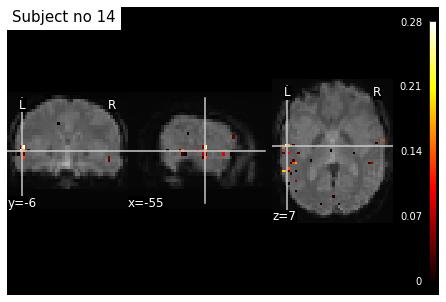

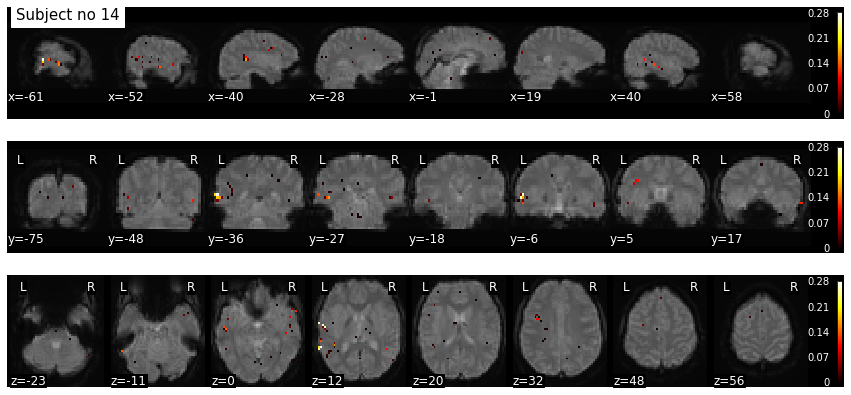

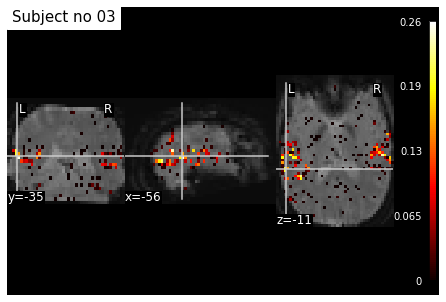

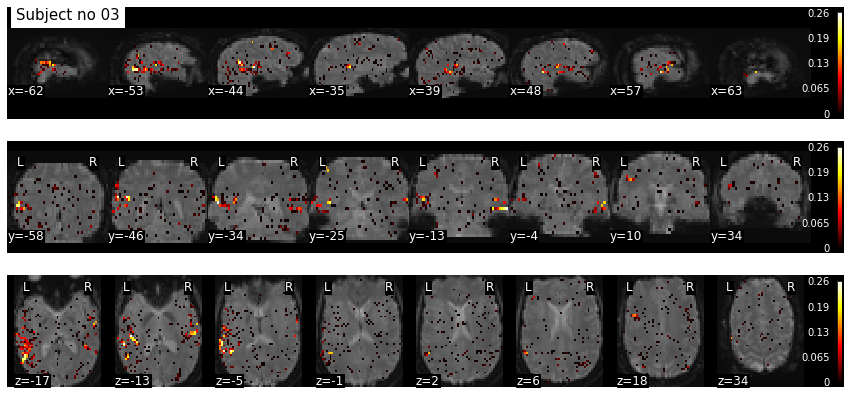

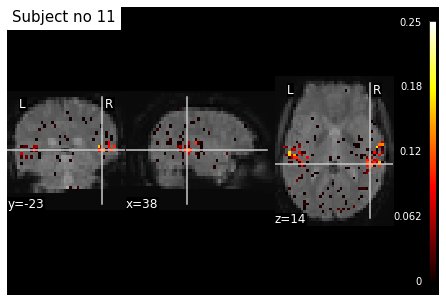

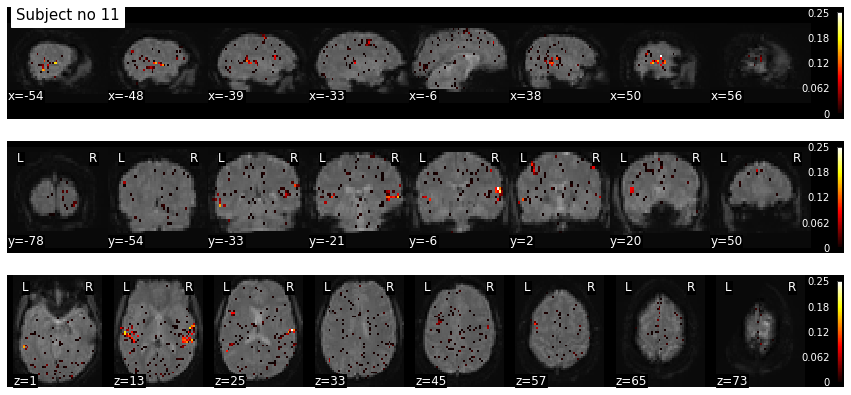

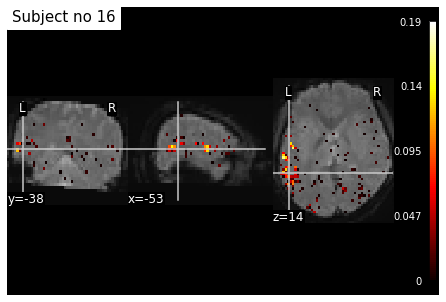

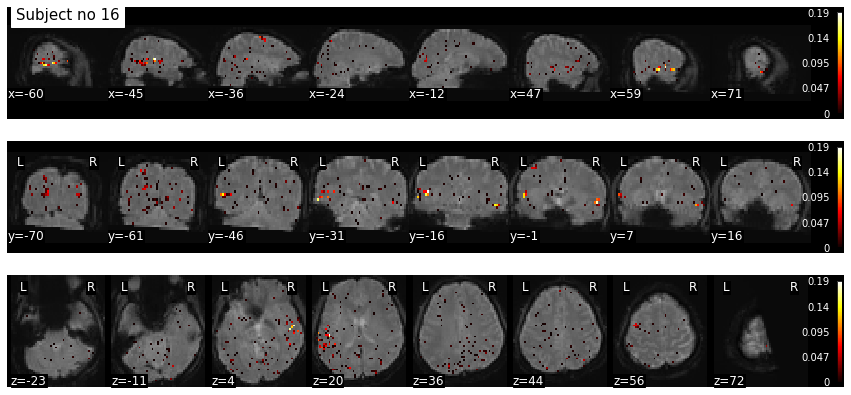

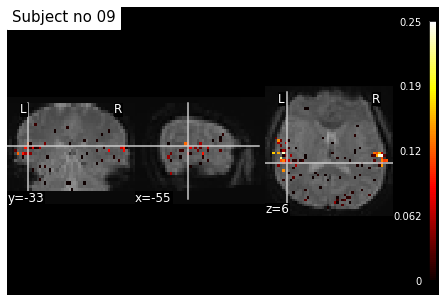

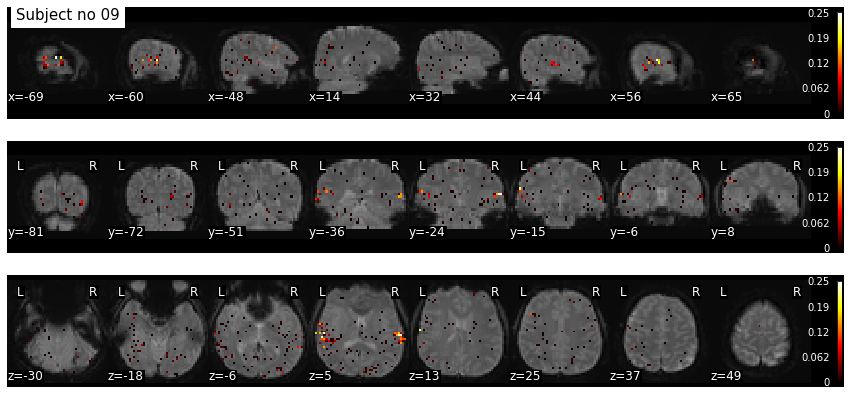

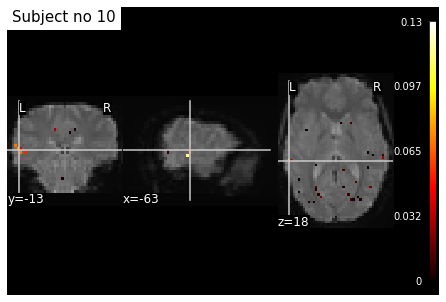

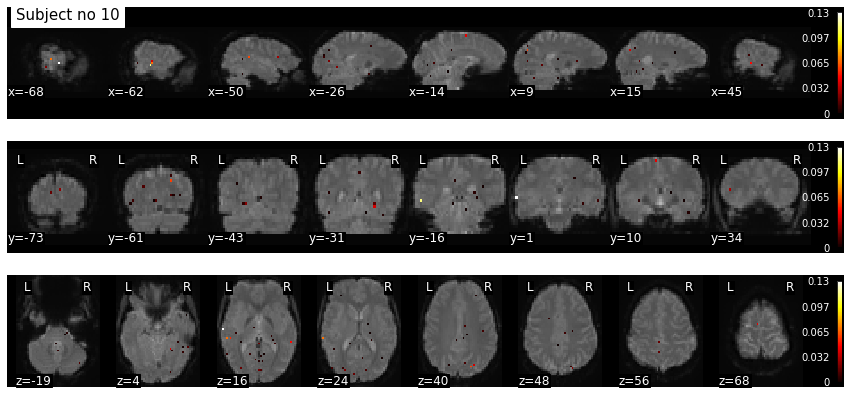

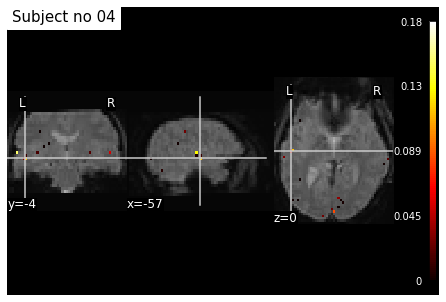

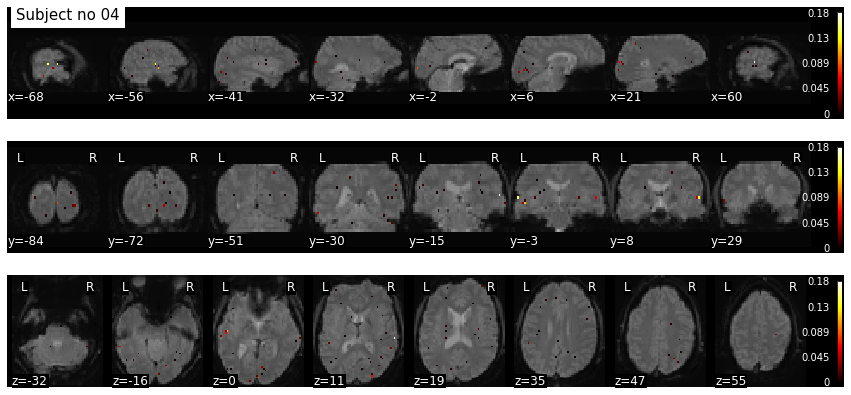

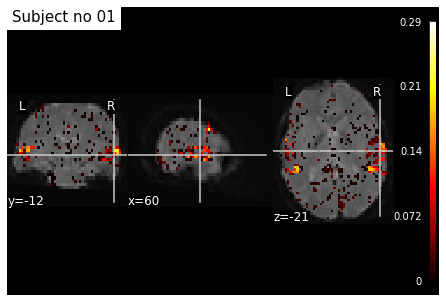

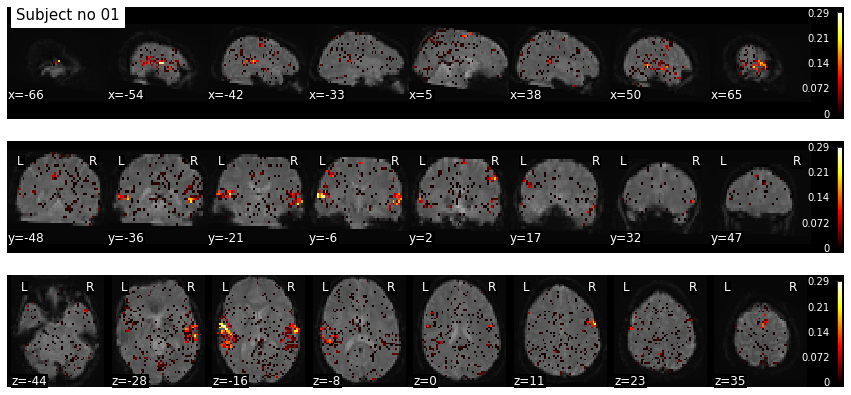

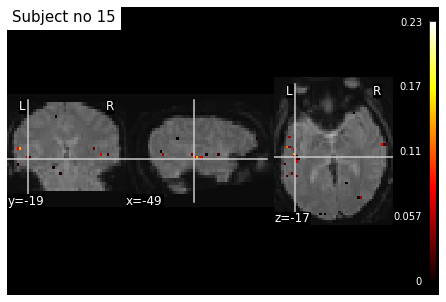

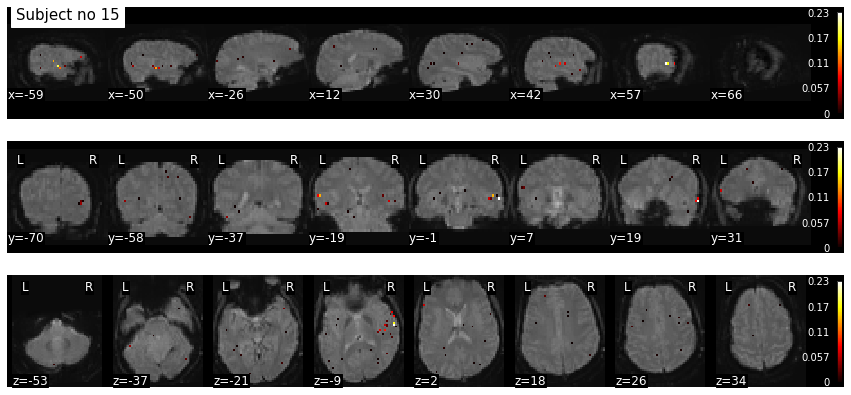

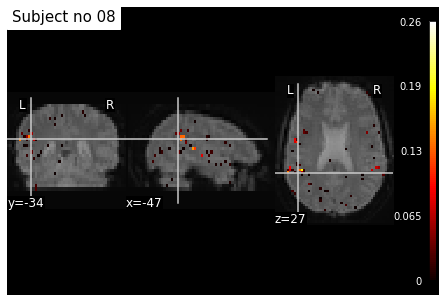

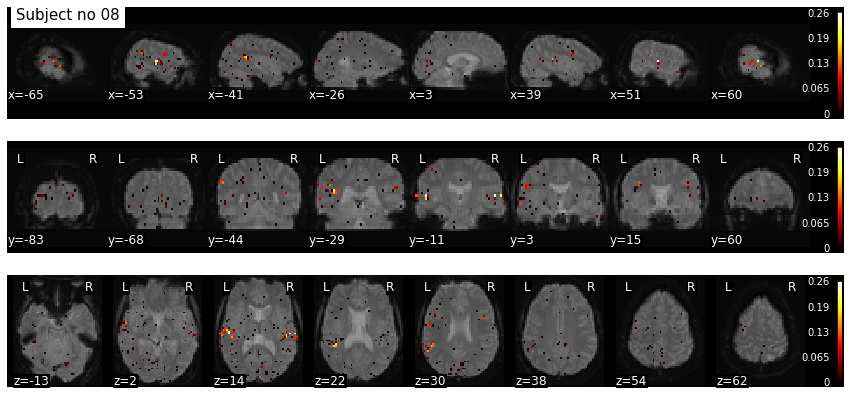

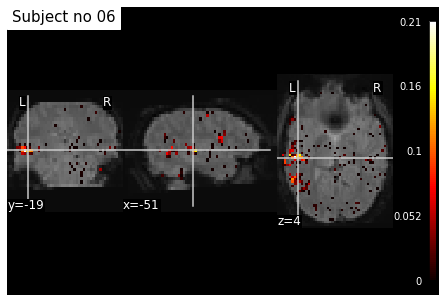

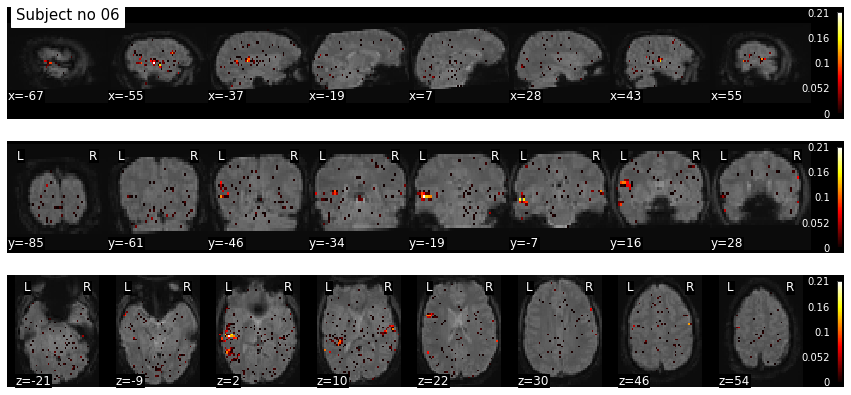

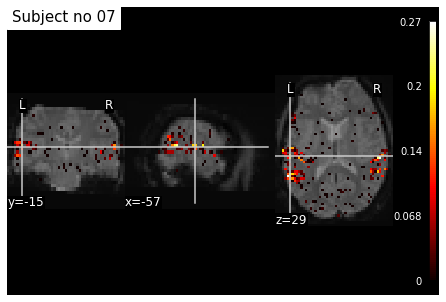

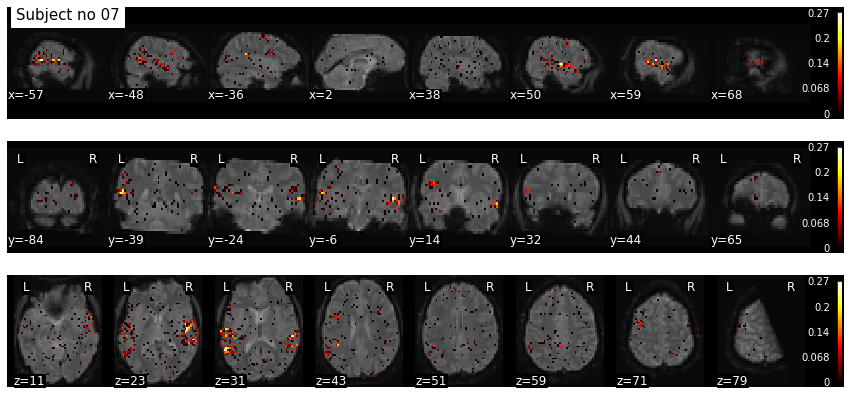

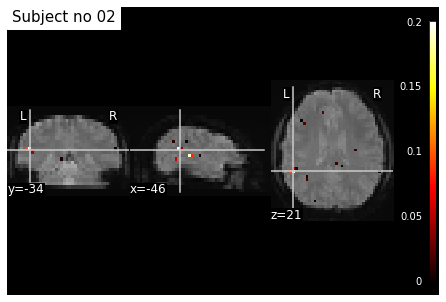

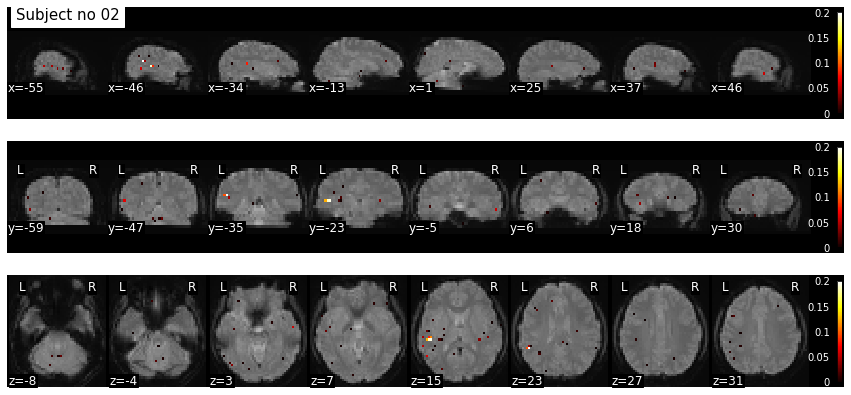

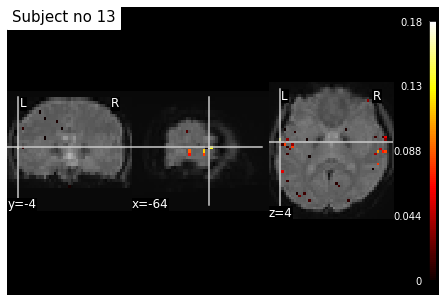

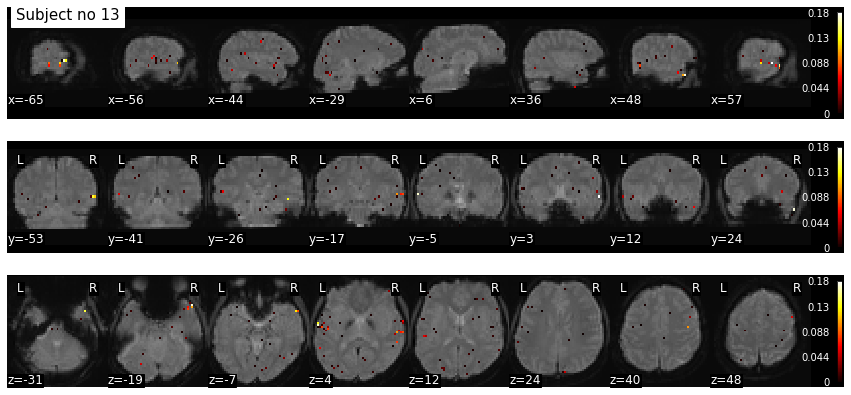

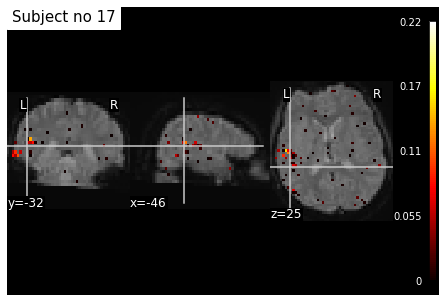

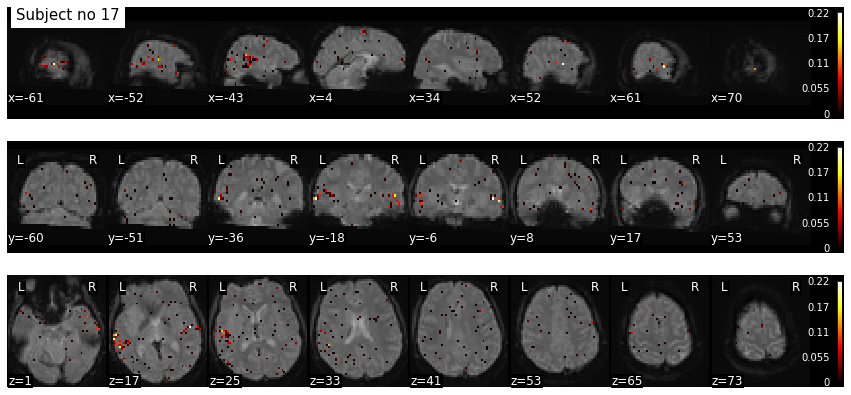

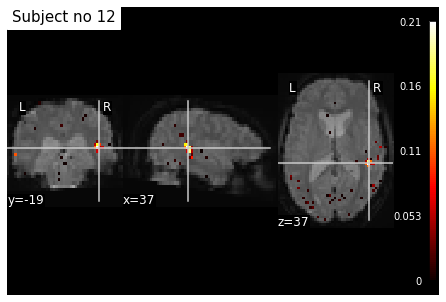

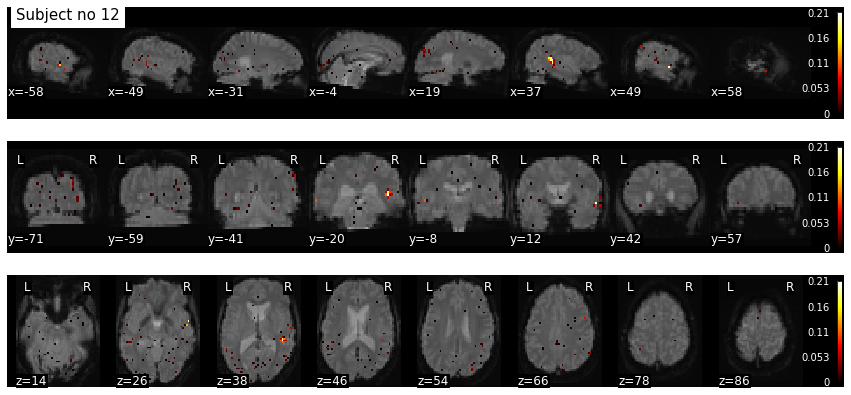

In [141]:
for curnpz in listnpz:
    best_scores = pd.DataFrame({'scores' : np.load(curnpz)['scores']})
    subject = int(curnpz.split('_')[0][-2:]) #getid
    fmri_data, fmri_mean,masker = load_fmri(subject)
    plot_mri(subject,masker,best_scores)

    

-------